In [1]:
pip install scikit-learn statsmodels arch seaborn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 13.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Time Series is a sequence of data points collected or recorded at specific time intervals. Time series data allows us to analyze trends, patterns and variations over time and is commo nly used in fields such as finance, economics, weather forecasting and stock market analysis.

Key Components:
- Trend
- Seasonality
- Cyclic Patterns
- Noise

In [2]:
#Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from arch import arch_model

#Load the CSV Data
data = pd.read_csv('/kaggle/input/nvidia-stocks-historical-data/nvidia.csv', parse_dates=["Date"])
data.set_index("Date", inplace=True)

**Basic Data Overview & Summary**

In [3]:
print("First 5 rows of the dataset:")
print(data.head())

print("\nSummary statistics of the dataset")
print(data.describe())

#Check for missing values
print("\nMissing Values in each column:")
print(data.isnull().sum())

First 5 rows of the dataset:
              Open    High     Low   Close     Volume  Adj Close
Date                                                            
2023-01-03  14.851  14.996  14.096  14.315  401277000  14.305581
2023-01-04  14.567  14.853  14.241  14.749  431324000  14.739295
2023-01-05  14.491  14.564  14.148  14.265  389168000  14.255614
2023-01-06  14.474  15.010  14.034  14.859  405044000  14.849225
2023-01-09  15.284  16.056  15.141  15.628  504231000  15.617719

Summary statistics of the dataset
             Open        High         Low       Close        Volume  \
count  448.000000  448.000000  448.000000  448.000000  4.480000e+02   
mean    64.193085   65.402489   62.910025   64.237370  4.504371e+08   
std     35.880173   36.613675   34.981482   35.825875  1.596547e+08   
min     14.474000   14.564000   14.034000   14.265000  1.697320e+08   
25%     40.477000   41.179751   39.845001   40.456500  3.547021e+08   
50%     48.164499   48.571501   47.447500   48.043001  

**Correlation HeatMap**

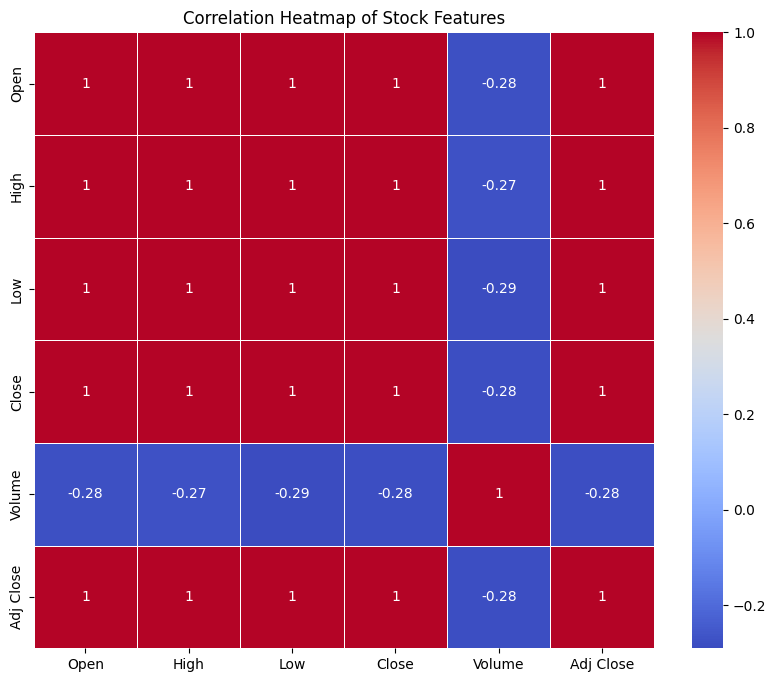

In [4]:
#Plot Correlation Heatmap
plt.figure(figsize=(10,8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Stock Features")
plt.show()

Perfect postive correlation between the Open, High, Low, Close, Adj Close columns. This indicates these values move together very closely. This is common in stock data because these values are often interdependent for a single trading day.

Volume has a weak negative correlation with all other price-related columns. This could indicate that higher trading volumes doesn't necessarily lead to significant changes in NVIDIA's stock price within this dataset

**Time-Series Analysis**

**Closing Price Over Time**

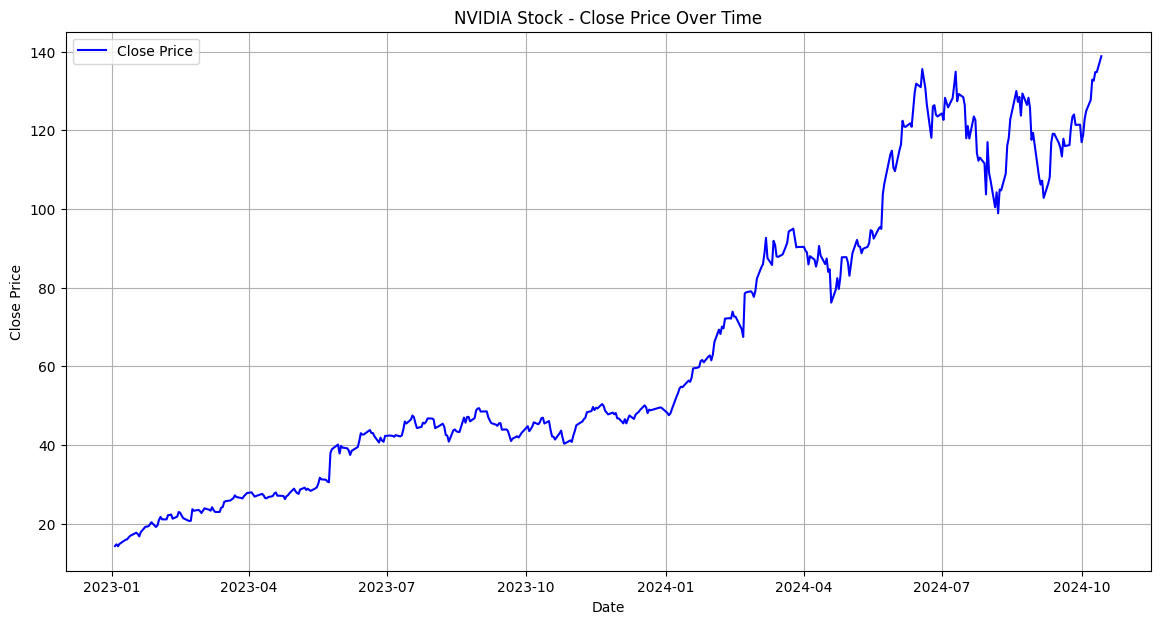

In [5]:
#Plot the closing price over time
plt.figure(figsize=(14,7))
plt.plot(data["Close"], label="Close Price", color="blue")
plt.title("NVIDIA Stock - Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

**Volume Analysis Over Time**

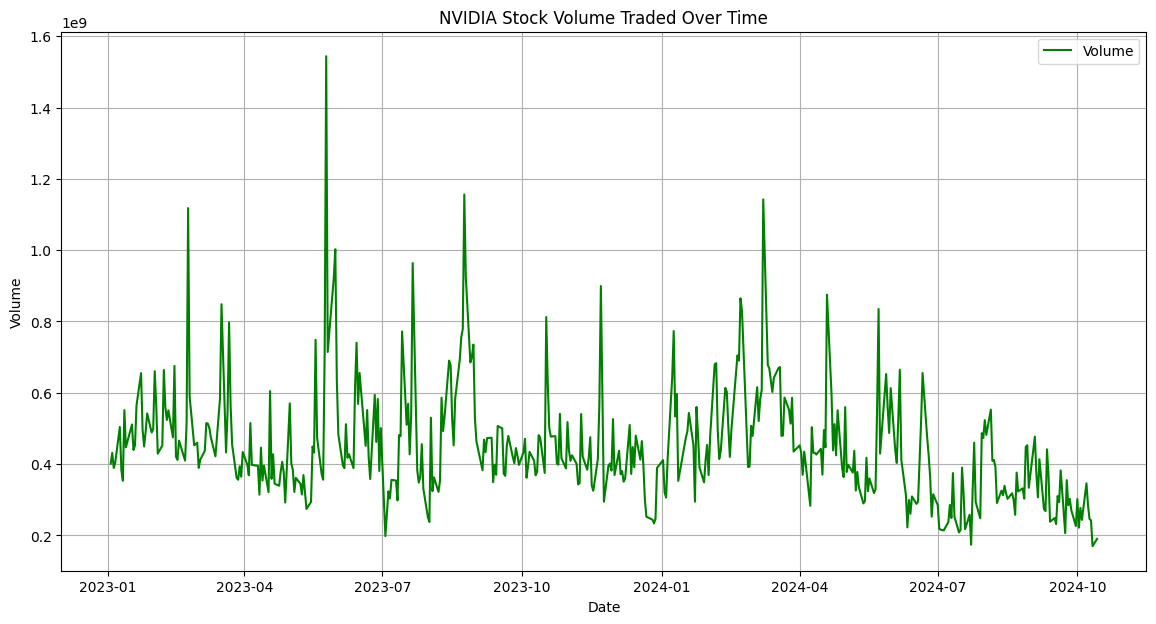

In [6]:
plt.figure(figsize=(14,7))
plt.plot(data["Volume"], label="Volume", color="green")
plt.title("NVIDIA Stock Volume Traded Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

Trading Volume of NVIDIA Stock over time -> number of shares traded on each day within the specified date range


**Closing Price with Moving Averages**

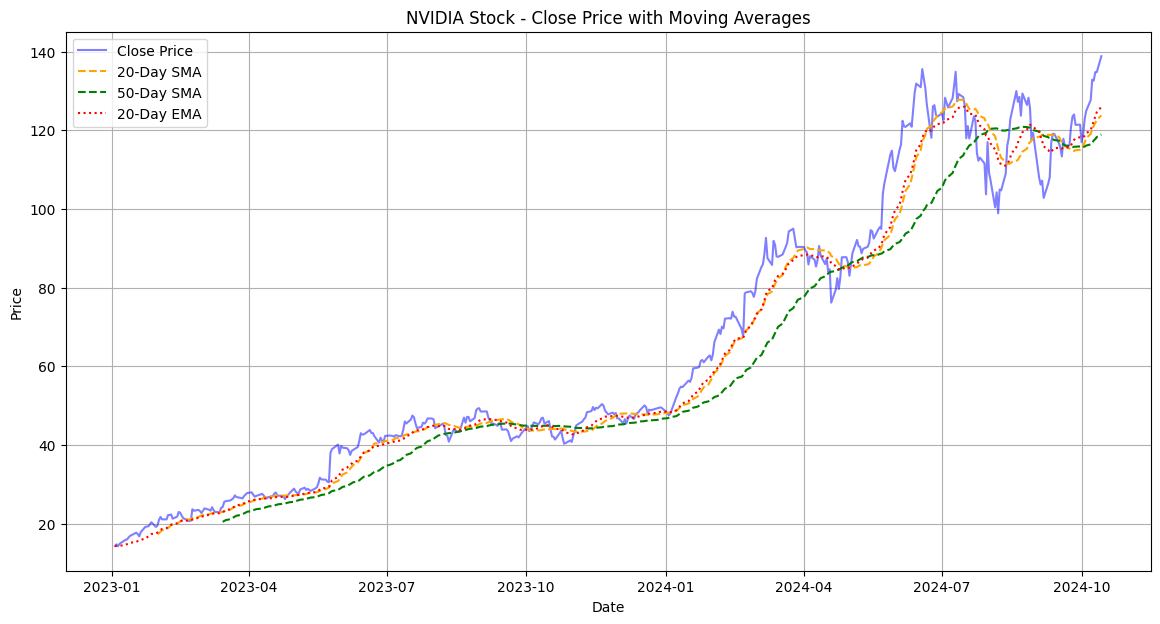

In [7]:
#Calculate Moving Averages
data["SMA_20"] = data["Close"].rolling(window=20).mean()
data["SMA_50"] = data["Close"].rolling(window=50).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()

#Plot Close Price with Moving Averages
plt.figure(figsize=(14,7))
plt.plot(data["Close"], label="Close Price", color="blue", alpha=0.5)
plt.plot(data["SMA_20"], label="20-Day SMA", color="orange", linestyle="--")
plt.plot(data['SMA_50'], label='50-Day SMA', color='green', linestyle='--')
plt.plot(data['EMA_20'], label='20-Day EMA', color='red', linestyle=':')
plt.title('NVIDIA Stock - Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Moving Average is reduces noise (small fluctuations) and shows trend more clearly.

The overall trend from early 2023 shows an upward movement indicating that NVIDIA'S stock has generally been increasing over this period.

EMA vs SMA -> 20-day EMA is slightly closer to the actual closing price than the 20-day SMA because it reacts faster to recent changes

**Statistical Modeling & Analysis**

**ARIMA Time-Series Forecasting**

AutoRegressive Integrated Moving Average
Popular model used for time series forecasting, especially when there is some structure in the data (such as trend or seasonality) but not strong seasonal patterns

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/p

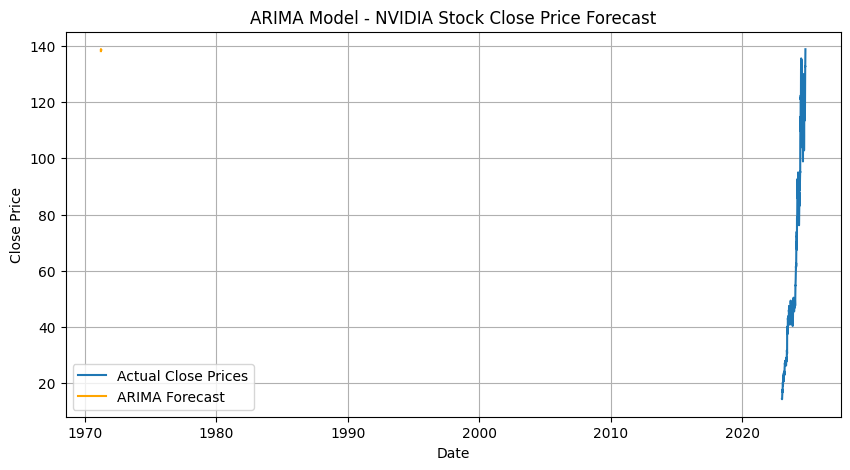

In [8]:
#use ARIMA model to forecast the future values of a stock's close prices
def arima_forecasting(data):
    close_prices = data["Close"].dropna() #remove any missing NaN values
    model = ARIMA(close_prices, order=(5,1,0)) 
    model_fit = model.fit() #fits ARIMA model to the data
    forecast = model_fit.forecast(steps=10) #generate forecast, forecast will contain the predicted close prices for the next 10 days

    #Plot actual vs forecast
    plt.figure(figsize=(10,5))
    plt.plot(close_prices, label="Actual Close Prices")
    plt.plot(forecast, label="ARIMA Forecast", color="orange")
    plt.title("ARIMA Model - NVIDIA Stock Close Price Forecast")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

arima_forecasting(data)

**Seasonal Decomposition**

method used in time-series analysis to separate a time series into different components:
- trend: long term increase or decrease in the data
- seasonal: patterns that repeat over a known, fixed period
- residual: remaining part of the data after removing the trend and seasonal components, captures irregularities and noise

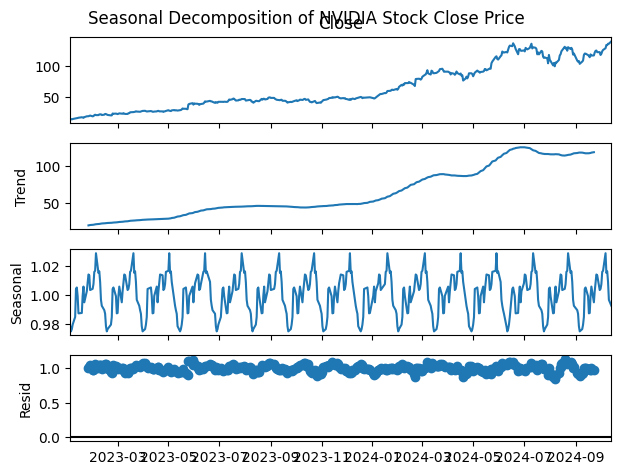

In [9]:
def seasonal_decomposition(data):
    close_prices = data["Close"].dropna()
    result = seasonal_decompose(close_prices, model="multiplicative", period=30)
    result.plot()
    plt.suptitle("Seasonal Decomposition of NVIDIA Stock Close Price")
    plt.show()

seasonal_decomposition(data)

**Machine Learning for Price Prediction**

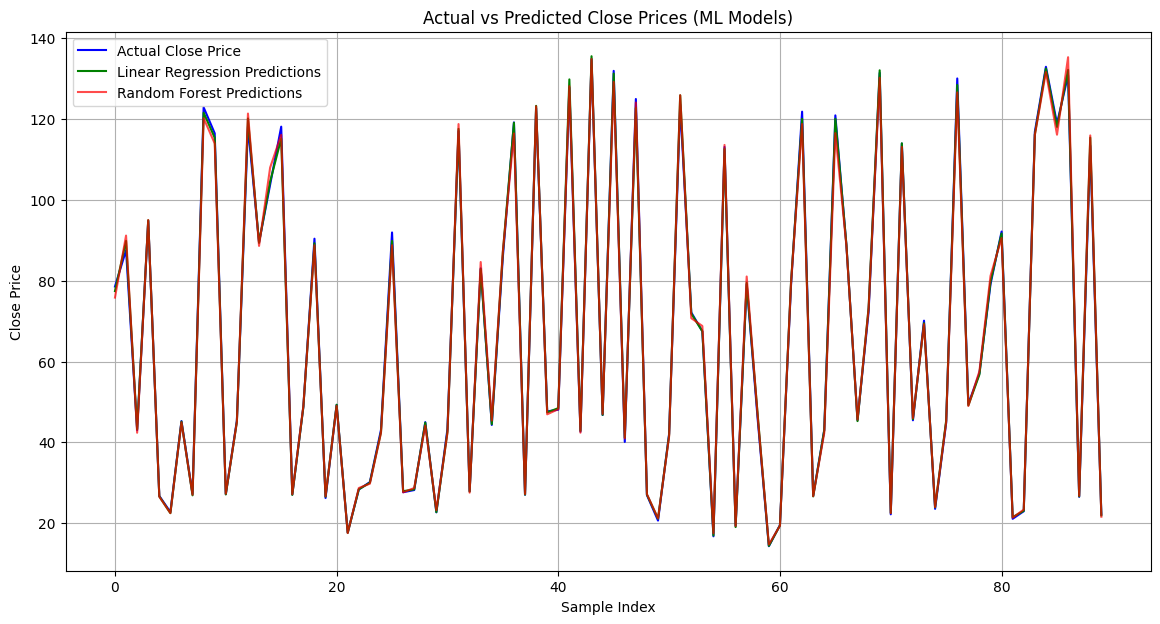

In [10]:
#Prepare the dataset for ML
data["Day"] = data.index.day
data["Month"] = data.index.month
data["Year"] = data.index.year

features = data[["Open", "High", "Low", "Day", "Month", "Year"]].fillna(0)
target = data["Close"].fillna(0)

#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

#Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

#Plot Linear Regression vs Random Forest Predictions
plt.figure(figsize=(14,7))
plt.plot(y_test.values, label="Actual Close Price", color="blue")
plt.plot(lr_predictions, label="Linear Regression Predictions", color="green")
plt.plot(rf_predictions, label="Random Forest Predictions", color="red", alpha=0.7)
plt.title("Actual vs Predicted Close Prices (ML Models)")
plt.xlabel("Sample Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()